# What have we done?

## Step 1: Conversion of text files to csv
#### We converted traditional text files to csv file, extracting the common pattern. We extracted bunch of fields such as *Salary, Duty, Requirements, where to Apply, Deadline, etc.* The extraction was done with regular expression and not AI or Machine Learning. Although doing it through Machine Learning would be fun too.

### Step 0 - Importing all libraries defining useful functions
- Importing Libraries

In [37]:
import numpy as np
import pandas as pd 
import re
import math
import gensim
import spacy
from nltk.tokenize import word_tokenize

# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

import os
print(os.listdir("../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Job Bulletins")[0:5])


['CHIEF MANAGEMENT ANALYST 9182 020918.txt', 'FINANCIAL ANALYST 1549 020218.txt', 'GEOGRAPHIC INFORMATION SYSTEMS CHIEF  7211 030416.txt', 'PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECHNICIAN 7531 090916 TRACK CHANGES.txt', 'PARKING METER TECHNICIAN SUPERVISOR 3757 2017.txt']


In [38]:
#Loading wiki's word2vec embedding
embed_model = gensim.models.KeyedVectors.load_word2vec_format("../input/ai-bootcamp/wiki-news-300d-1M.vec")  

# Functions 

- Function to delete special regex. Eg - special chars in text or $, in numbers.

In [39]:
def clean_with_regex(df0,col_name,regex):
    df = df0.copy()
    
    for idx,each in enumerate(df[col_name]):
        try:
            df.iloc[idx,df.columns.get_loc(col_name)] = re.sub(regex, '', each) 
        except:
            #print(each)
            #print("Error with row: "+str(idx)+" and column: "+col_name)
            continue
    return df[col_name].copy()

- Function to remove stop words

In [40]:
def remove_stop_words(df,col_name):
    
    #Lowercase all words
    for idx,each in enumerate(df[col_name]):
        try:
            df.iloc[idx][col_name] = each.lower()
        except:
            continue
    
    #Remove stopwords
    
    for idx,each in enumerate(df[col_name]):
        df.iloc[idx][col_name] = " ".join(select_stop_words(each))
    
    return df

In [41]:

#Function obtained from https://www.programcreek.com/python/example/106181/sklearn.feature_extraction.stop_words.ENGLISH_STOP_WORDS and is open source & modified
def select_stop_words(word_list):
    out = []
    nlp = spacy.load("en")
    for word in word_list.split(' '):
        #Removing special characters - •,! etc
        word = re.sub('[^\s\w]','',word)
        sentence = nlp(word)
        
        if sentence[0].is_stop:
            continue
        out.append(word)
    return out 

- Function for getting TF-IDF matrix

In [42]:
def tf_idf(df,col_name):
    
    vec = TfidfVectorizer(ngram_range=(1,3))
    resp = vec.fit_transform(df[col_name])
    
    new_cols_vocab = []
    
    sorted_x = sorted(vec.vocabulary_.items(), key=lambda kv: kv[1])
    for each in sorted_x:
        new_cols_vocab.append(each[0])
        
    dfz1 = pd.DataFrame(resp.toarray(),columns=new_cols_vocab)
    dfz2 = df.merge(dfz1, how = 'inner', left_index = True, right_index=True)
        
    return resp,vec,dfz2

- Function for applying LSA

In [43]:

def svd_apply_train(tfidf_matrix, k):
    
    svd = TruncatedSVD(n_components=k, n_iter=100)
    svd_lsa = svd.fit_transform(tfidf_matrix)
    svd_lsa = Normalizer(copy=False).fit_transform(svd_lsa)
    
    return svd,svd_lsa

### Step 1: Visualizing text file (If you've seen the file a lot of times please do skip)

In [44]:
zx = open("../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Job Bulletins/ARTS ASSOCIATE 2454 072117 REV 072817.txt")
print(zx.read())
zx.close()

ARTS ASSOCIATE
Class Code:       2454
                                                                                                                             Open Date:  07-21-17
                                                                      Revised 07-28-17
(Exam Open to All, including Current City Employees)
ANNUAL SALARY

$48,797 to $71,326

NOTES:

1. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.
2. The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.

DUTIES

An Arts Associate performs a broad range of entry-level professional arts administration work in the areas of: community and public arts program coordination; cultural grant administration; performing arts and festival production; preparation and development of marketing materials; project management in public art, mural commissioning, and conservation of artworks; and ar

### Step 2: Using Regex to extract data to a csv file.
- Here every row in CSV file is a text file and regular expression is used to extract the data. Every section is in the format - 

   - [UPPERCASE TITLE][:] [\n - Newline Character] - (Colon may or may not be present *)
   - [New Line]
   - [Text] [\n - Newline Character] - (Content of section)
   - [New Line]

In [45]:
#Column name for dataframe
col_lst = ['ANNUAL SALARY','DUTIES','REQUIREMENTS','PROCESS','WHERE TO APPLY','APPLICATION DEADLINE','SELECTION','NOTE','NOTICE']
col_lst2 = ['position','ANNUAL SALARY','DUTIES','REQUIREMENTS','PROCESS','WHERE TO APPLY','APPLICATION DEADLINE','SELECTION','NOTE','NOTICE']
row_lst = []
df = pd.DataFrame(columns=col_lst)

ij=0
for each in os.listdir("../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Job Bulletins"):
    base_pth = "../input/data-science-for-good-city-of-los-angeles/cityofla/CityofLA/Job Bulletins/"
    fp = open(base_pth+each)
    
    try:
        section_start_pos = []
        emp_dict = {}

        #Extracting job title
        title = fp.readline()
        emp_dict['position'] = title

        txt = fp.read()
        for section in re.finditer(r'\n[A-Z]+[ A-Z/]*[:]?\n{2}.*', txt):
            section_start_pos.append(section.span()[0])

        for i in range (0,len(section_start_pos)):
            start_pos = section_start_pos[i]

            if (i == len(section_start_pos)-1):
                end_pos = len(txt)
            else:
                end_pos = section_start_pos[i+1]

            tmp_txt = txt[start_pos:end_pos]

            for each3 in col_lst:
                if (re.finditer(each3,tmp_txt)):
                    for each2 in re.finditer(each3,tmp_txt):
                        emp_dict[each3] = str(tmp_txt[0:each2.span()[0]] + tmp_txt[each2.span()[1]:])  
    
    except:
        print("Error in : "+each+" - "+str(ij))
        continue
    ij+=1
    row_lst.append(emp_dict)
    
#print(row_lst)
df = pd.DataFrame(row_lst,columns=col_lst2)


Error in : POLICE COMMANDER 2251 092917.txt - 532


## This is how the csv file looks.
- The file is not at all cleaned and as you can see has newline characters.

In [46]:
df.to_csv('conv_from_files.csv')
df.head()

,position,ANNUAL SALARY,DUTIES,REQUIREMENTS,PROCESS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION,NOTE,NOTICE
0,CHIEF MANAGEMENT ANALYST\n,"\n\n\n$123,667 to $179,944\n",\n\n\nA Chief Management Analyst directs and m...,NaN,\nSELECTION \n\nAfter meeting minimum qualific...,\n\n\nApplications will only be accepted on-li...,\n\n\nApplications must be submitted on-line b...,\n PROCESS\n\nAfter meeting minimum qualificat...,\nS:\n\n1. Appointment to this position is sub...,NaN
1,FINANCIAL ANALYST\n,"\n\n\n$68,159 to $100,370 and $78,989 to $115,...",\n\n\nA Financial Analyst analyzes proposals f...,\n/MINIMUM QUALIFICATIONS\n\n1. Graduation fro...,\nSELECTION \n\nAfter meeting minimum qualific...,\n\n\nApplications and Qualifications Question...,\n\n\nApplications and Qualifications Question...,\n PROCESS\n\nAfter meeting minimum qualificat...,\nS:\n\n1. Applications are accepted subject t...,NaN
2,GEOGRAPHIC INFORMATION SYSTEMS CHIEF\n,"\n\n\n$85,127 to $124,423\n",\n\n\nA Geographic Information Systems Chief d...,NaN,\nSELECTION \n\nExamination Weight: Interview...,\n\n\nApplications will only be accepted on-li...,\n\n\nApplications must be received by THURSDA...,\n PROCESS\n\nExamination Weight: Interview ....,\nSELECTION PROCESS\n\nExamination Weight: In...,NaN
3,PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECH...,"\n\n\n$88,447 to $109,870 and $98,616 to $122,...",\n\n\nA Principal Electrical Engineering Draft...,NaN,\nSELECTION \n\nAfter meeting minimum qualific...,\n\n\nApplications will only be accepted on-li...,\n\n\nApplications must be received by THURSDA...,\n PROCESS\n\nAfter meeting minimum qualificat...,\nS:\n\n1. This examination is based on a vali...,NaN
4,PARKING METER TECHNICIAN SUPERVISOR\n,"\n\n\n$53,390 to $75,982 and $57,649 to $81,99...",\n\n\nA Parking Meter Technician Supervisor as...,NaN,\nSELECTION \n\nAfter meeting minimum qualific...,\n\n\nApplications will only be accepted on-li...,\n\n\nApplications must be received by THURSDA...,\n PROCESS\n\nAfter meeting minimum qualificat...,\nS:\n\n1. This examination is based on a vali...,NaN


*Conversion and basic sectioning of text files end here.*

In [47]:
print(df['position'].head())

0                           CHIEF MANAGEMENT ANALYST\n
1                                  FINANCIAL ANALYST\n
2               GEOGRAPHIC INFORMATION SYSTEMS CHIEF\n
3    PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECH...
4                PARKING METER TECHNICIAN SUPERVISOR\n
Name: position, dtype: object


In [48]:
#Removing \t & \n from differnt columns
col_to_be_clean = ['position','ANNUAL SALARY','DUTIES','REQUIREMENTS','PROCESS','WHERE TO APPLY','APPLICATION DEADLINE','SELECTION','NOTE','NOTICE']
for each in col_to_be_clean:
    regex = '(\n|\t)+'
    df[each] = clean_with_regex(df,each,regex)
    

- Now the titles look much cleaner.

In [49]:
df['position'].head()

0                             CHIEF MANAGEMENT ANALYST
1                                    FINANCIAL ANALYST
2                 GEOGRAPHIC INFORMATION SYSTEMS CHIEF
3    PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECH...
4                  PARKING METER TECHNICIAN SUPERVISOR
Name: position, dtype: object

In [50]:
df.head()

,position,ANNUAL SALARY,DUTIES,REQUIREMENTS,PROCESS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION,NOTE,NOTICE
0,CHIEF MANAGEMENT ANALYST,"$123,667 to $179,944",A Chief Management Analyst directs and manages...,NaN,"SELECTION After meeting minimum qualification,...",Applications will only be accepted on-line. Wh...,Applications must be submitted on-line by THUR...,"PROCESSAfter meeting minimum qualification, c...",S:1. Appointment to this position is subject t...,NaN
1,FINANCIAL ANALYST,"$68,159 to $100,370 and $78,989 to $115,487",A Financial Analyst analyzes proposals for con...,/MINIMUM QUALIFICATIONS1. Graduation from an a...,SELECTION After meeting minimum qualifications...,Applications and Qualifications Questionnaires...,Applications and Qualifications Questionnaires...,"PROCESSAfter meeting minimum qualifications, ...",S:1. Applications are accepted subject to revi...,NaN
2,GEOGRAPHIC INFORMATION SYSTEMS CHIEF,"$85,127 to $124,423",A Geographic Information Systems Chief develop...,NaN,SELECTION Examination Weight: Interview . . ....,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, MAR...",PROCESSExamination Weight: Interview . . . ....,SELECTION PROCESSExamination Weight: Intervie...,NaN
3,PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECH...,"$88,447 to $109,870 and $98,616 to $122,523",A Principal Electrical Engineering Drafting Te...,NaN,SELECTION After meeting minimum qualifications...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, SEP...","PROCESSAfter meeting minimum qualifications, ...",S:1. This examination is based on a validation...,NaN
4,PARKING METER TECHNICIAN SUPERVISOR,"$53,390 to $75,982 and $57,649 to $81,995","A Parking Meter Technician Supervisor assigns,...",NaN,"SELECTION After meeting minimum qualification,...",Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, OCT...","PROCESSAfter meeting minimum qualification, c...",S:1. This examination is based on a validation...,NaN


### Next we convert the text salary to actual numbers.
- 2 Additional columns for lower bound and upper bound

In [51]:
#Split annual income from text to numbers
col = 'ANNUAL SALARY'
regex_whole = '\$[0-9,]+ to \$[0-9,]+'
df['low_end_sal'] = -999
df['high_end_sal'] = -1

for idx,each in enumerate(df[col]):
    #print(each)
    if (type(each) is str):
        for section in re.finditer(regex_whole, each):
            s = section.start()
            e = section.end()
            
            each3 = each[s:e].split(' to ')
            
            regex_to_be_rem = '[$,]*'
            tmp_low_end = re.sub(regex_to_be_rem,'' , each3[0])
            tmp_high_end = re.sub(regex_to_be_rem, '', each3[1])
            
            df.iloc[idx,df.columns.get_loc('low_end_sal')] = int(tmp_low_end)
            df.iloc[idx,df.columns.get_loc('high_end_sal')] = int(tmp_high_end)
            break
       
    else:
        continue

In [52]:
df.head()

,position,ANNUAL SALARY,DUTIES,REQUIREMENTS,PROCESS,WHERE TO APPLY,APPLICATION DEADLINE,SELECTION,NOTE,NOTICE,low_end_sal,high_end_sal
0,CHIEF MANAGEMENT ANALYST,"$123,667 to $179,944",A Chief Management Analyst directs and manages...,NaN,"SELECTION After meeting minimum qualification,...",Applications will only be accepted on-line. Wh...,Applications must be submitted on-line by THUR...,"PROCESSAfter meeting minimum qualification, c...",S:1. Appointment to this position is subject t...,NaN,123667,179944
1,FINANCIAL ANALYST,"$68,159 to $100,370 and $78,989 to $115,487",A Financial Analyst analyzes proposals for con...,/MINIMUM QUALIFICATIONS1. Graduation from an a...,SELECTION After meeting minimum qualifications...,Applications and Qualifications Questionnaires...,Applications and Qualifications Questionnaires...,"PROCESSAfter meeting minimum qualifications, ...",S:1. Applications are accepted subject to revi...,NaN,68159,100370
2,GEOGRAPHIC INFORMATION SYSTEMS CHIEF,"$85,127 to $124,423",A Geographic Information Systems Chief develop...,NaN,SELECTION Examination Weight: Interview . . ....,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, MAR...",PROCESSExamination Weight: Interview . . . ....,SELECTION PROCESSExamination Weight: Intervie...,NaN,85127,124423
3,PRINCIPAL ELECTRICAL ENGINEERING DRAFTING TECH...,"$88,447 to $109,870 and $98,616 to $122,523",A Principal Electrical Engineering Drafting Te...,NaN,SELECTION After meeting minimum qualifications...,Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, SEP...","PROCESSAfter meeting minimum qualifications, ...",S:1. This examination is based on a validation...,NaN,88447,109870
4,PARKING METER TECHNICIAN SUPERVISOR,"$53,390 to $75,982 and $57,649 to $81,995","A Parking Meter Technician Supervisor assigns,...",NaN,"SELECTION After meeting minimum qualification,...",Applications will only be accepted on-line. Wh...,"Applications must be received by THURSDAY, OCT...","PROCESSAfter meeting minimum qualification, c...",S:1. This examination is based on a validation...,NaN,53390,75982


# Number of NaN in columns 
- Meaning entries where regex did not do a good job 

In [53]:
df.isna().sum()

position                  0
ANNUAL SALARY            49
DUTIES                    6
REQUIREMENTS            250
PROCESS                   3
WHERE TO APPLY            3
APPLICATION DEADLINE      7
SELECTION                 5
NOTE                      0
NOTICE                  568
low_end_sal               0
high_end_sal              0
dtype: int64

# Trying Self Organizing Maps

In [55]:
df2 = pd.DataFrame(columns = [x for x in range(0,len(embed_model['example']))])


for idx,each in enumerate(df['position']):
    df2.loc[idx] = np.zeros(len(embed_model['example']))
    for each2 in each.split(' '): 
        try:
            df2.loc[idx] += embed_model[each2.lower()]
        except:
            continue
    
from minisom import MiniSom    
som = MiniSom(20, 20, 300, sigma=1.0, learning_rate=0.5) # initialization of 6x6 SOM
som.train_random(df2.values, 100) # trains the SOM with 100 iterations

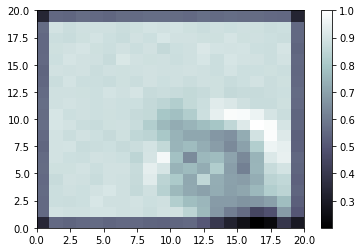

In [56]:
X = df2.values

from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()


# What were the next steps? (Incomplete from here on)
### Next we try to use the pre-trained word2vec wikipedia model to obtain aggregate summation vector of job titles. Thus titles such as Data Scienist and Data Engineer will be relatively closer. Next we use Self Organizing Map to create a map which will show all the relevant job titles close. After that we can use this map to do -
1. Create a radio visualization which could allow us to select one job title and show us job titles which are similar, which require similar skill and pay more.
2. To create a radio visualization where iterating through all jobs, one job title at a time will allow us to decide the similarity (distance from other) of job titles from real world pre-trained word2vec model. Using this similariy/distance to decide whether the job description/duty needs to be changed or re-designed. For eg - if Data Scientist and Data Engineer would have less distance, from the Word2Vec embedding model, so by using TF-IDF and LSA (Latent Semantic Analysis) on Job Duties and try to get the distance between them and depending on the distance between duties and distance from Self Organising Maps re-design one or both of them.

# Try to group all Job Titles and make salary visualization

In [54]:
df['vec'] = 

for idx,each in enumerate(df['position']):
    for each2 in each.split(' '):
        df.iloc[idx,df.columns.get_loc('vec')] += embed_model[each2]
    break
    
    
# Determine where the visualization will be rendered
output_notebook()  # Render inline in a Jupyter Notebook

# Set up the figure(s)
fig = figure()  # Instantiate a figure() object

# Connect to and draw the data

-----xxxx------
dot = figure(title="Categorical Dot Plot", tools="", toolbar_location=None,
            y_range=factors, x_range=[0,100])

dot.segment(0, factors, x, factors, line_width=2, line_color="green", )
dot.circle(x, factors, size=15, fill_color="orange", line_color="green", line_width=3, )

-----xxxx------
# Organize the layout

# Preview and save 
show(fig)

SyntaxError: invalid syntax (<ipython-input-54-92f73014d23b>, line 1)

# Next try to check using 'Duties' section how different jobs are:

In [ ]:
col_name = 'DUTIES'
df = remove_stop_words(df,col_name)